In [34]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [35]:
path = "hdfs:///data/hour_noheader.csv"
raw_data = sc.textFile(path)
num_data = raw_data.count()
records = raw_data.map(lambda x: x.split(","))
first = records.first()
print first
print num_data


[u'1', u'2011-01-01', u'1', u'0', u'1', u'0', u'0', u'6', u'0', u'1', u'0.24', u'0.2879', u'0.81', u'0', u'3', u'13', u'16']
17379


In [36]:

def get_mapping(rdd, idx):
    return rdd.map(lambda fields: fields[idx]).distinct().zipWithIndex().collectAsMap()

#test
print "Mapping of first categorical feature column: %s" % get_mapping(records, 2)


Mapping of first categorical feature column: {u'1': 0, u'3': 1, u'2': 2, u'4': 3}


In [37]:
mappings = [get_mapping(records, i) for i in range(2,10)]
cat_len = sum(map(len, mappings))
num_len = len(records.first()[11:15])
total_len = num_len + cat_len
print "Feature vector length for categorical features: %d" % cat_len
print "Feature vector length for numerical features: %d" % num_len
print "Total feature vector length: %d" % total_len



Feature vector length for categorical features: 57
Feature vector length for numerical features: 4
Total feature vector length: 61


Text(0.5,1,u'Distribution of target variable values')

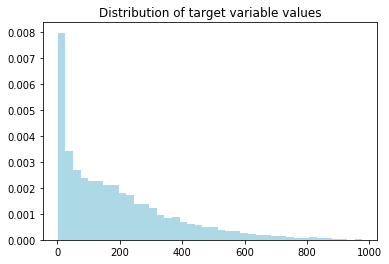

In [38]:
#explore target variable
targets = records.map(lambda r: float(r[-1])).collect()
plt.hist(targets, bins=40, color='lightblue', normed=True)
fig = matplotlib.pyplot.gcf()
plt.title("Distribution of target variable values")



In [39]:
#Creating feature vectors for the linear model
#The next step is to use our extracted mappings to convert the categorical features to
#binary-encoded features

from pyspark.mllib.regression import LabeledPoint
import numpy as np

def extract_features(record):
    cat_vec = np.zeros(cat_len)
    i = 0
    step = 0
    for field in record[2:9]:
        m = mappings[i]
        idx = m[field]
        cat_vec[idx + step] = 1
        i = i + 1
        step = step + len(m)
    num_vec = np.array([float(field) for field in record[10:14]])
    return np.concatenate((cat_vec, num_vec))

def extract_label(record):
    return float(record[-1])


In [40]:
data = records.map(lambda r: LabeledPoint(extract_label(r), extract_features(r)))
#Let's inspect the first record in the extracted feature RDD:
first_point = data.first()
print "Raw data: " + str(first[2:])
print "Label: " + str(first_point.label)
print "Linear Model feature vector:\n" + str(first_point.features)
print "Linear Model feature vector length: " + str(len(first_point.
features))


Raw data: [u'1', u'0', u'1', u'0', u'0', u'6', u'0', u'1', u'0.24', u'0.2879', u'0.81', u'0', u'3', u'13', u'16']
Label: 16.0
Linear Model feature vector:
[1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.24,0.2879,0.81,0.0]
Linear Model feature vector length: 61


As we can see, we converted the raw data into a feature vector made up of the binary
categorical and real numeric features, and we indeed have a total vector length of 61.


#Creating feature vectors for the decision tree

Decision tree models typically work on raw features (that is, it is not required to convert categorical features into a binary vector encoding; they can, instead, be used directly). Therefore, we will create a separate function to extract the decision tree feature vector, which simply converts all the values to floats and wraps them in a numpy array


In [41]:
def extract_features_dt(record):
    return np.array(map(float, record[2:14]))
data_dt = records.map(lambda r: LabeledPoint(extract_label(r),
extract_features_dt(r)))
first_point_dt = data_dt.first()
print "Decision Tree feature vector: " + str(first_point_dt.features)
print "Decision Tree feature vector length: " + str(len(first_point_dt.features))


Decision Tree feature vector: [1.0,0.0,1.0,0.0,0.0,6.0,0.0,1.0,0.24,0.2879,0.81,0.0]
Decision Tree feature vector length: 12


In [42]:
from pyspark.mllib.regression import LinearRegressionWithSGD
from pyspark.mllib.tree import DecisionTree


In [43]:
#Training a regression model
linear_model = LinearRegressionWithSGD.train(data, iterations=10,
step=0.1, intercept=False)
true_vs_predicted = data.map(lambda p: (p.label, linear_model.predict(p.features)))
print "Linear Model predictions: " +str(true_vs_predicted.take(5))


Linear Model predictions: [(16.0, 117.89250386724846), (40.0, 116.2249612319211), (32.0, 116.02369145779235), (13.0, 115.67088016754433), (1.0, 115.56315650834317)]


In [44]:
#Training a desicion tree model
dt_model = DecisionTree.trainRegressor(data_dt,{})
preds = dt_model.predict(data_dt.map(lambda p: p.features))
actual = data.map(lambda p: p.label)
true_vs_predicted_dt = actual.zip(preds)
print "Decision Tree predictions: " + str(true_vs_predicted_dt.take(5))
print "Decision Tree depth: " + str(dt_model.depth())
print "Decision Tree number of nodes: " + str(dt_model.numNodes())


Decision Tree predictions: [(16.0, 54.913223140495866), (40.0, 54.913223140495866), (32.0, 53.171052631578945), (13.0, 14.284023668639053), (1.0, 14.284023668639053)]
Decision Tree depth: 5
Decision Tree number of nodes: 63


In [45]:
#Evaluating the performance of regression models
#define Mean Square Error
def squared_error(actual, pred):
    return (pred - actual)**2

#define Mean Absolute Error
def abs_error(actual, pred):
    return np.abs(pred - actual)

#define Root Mean Squared Log Error (used in kaggle competition for the specific dataset)
# https://www.kaggle.com/c/bike-sharing-demand#evaluation
def squared_log_error(pred, actual):
    return (np.log(pred + 1) - np.log(actual + 1))**2


In [46]:
 #Performance metrics on the bike sharing dataset
mse= true_vs_predicted.map(lambda (t, p): squared_error(t, p)).mean()
mae = true_vs_predicted.map(lambda (t, p): abs_error(t, p)).mean()
rmsle = np.sqrt(true_vs_predicted.map(lambda (t, p): squared_log_error(t, p)).mean())
print "Linear Model - Mean Squared Error: %2.4f" % mse
print "Linear Model - Mean Absolute Error: %2.4f" % mae
print "Linear Model - Root Mean Squared Log Error: %2.4f" % rmsle
print "-------------------------------------------------------"
mse_dt = true_vs_predicted_dt.map(lambda (t, p): squared_error(t, p)).mean()
mae_dt = true_vs_predicted_dt.map(lambda (t, p): abs_error(t, p)).mean()
rmsle_dt = np.sqrt(true_vs_predicted_dt.map(lambda (t, p): squared_log_error(t, p)).mean())
print "Decision Tree - Mean Squared Error: %2.4f" % mse_dt
print "Decision Tree - Mean Absolute Error: %2.4f" % mae_dt
print "Decision Tree - Root Mean Squared Log Error: %2.4f" % rmsle_dt


Linear Model - Mean Squared Error: 30679.4539
Linear Model - Mean Absolute Error: 130.6429
Linear Model - Root Mean Squared Log Error: 1.4653
-------------------------------------------------------
Decision Tree - Mean Squared Error: 11611.4860
Decision Tree - Mean Absolute Error: 71.1502
Decision Tree - Root Mean Squared Log Error: 0.6251


In [47]:
#LINEAR REGRESSION MODEL
#split data to training and test
(trainingData, testData) = data.randomSplit([0.8, 0.2])
linear_model = LinearRegressionWithSGD.train(trainingData, iterations=10, step=0.1, intercept=False)
#true_vs_predicted = data.map(lambda p: (p.label, linear_model.predict(p.features)))
predictions = linear_model .predict(testData.map(lambda x: x.features))
labelsAndPredictions = testData.map(lambda lp: lp.label).zip(predictions)
testmse= labelsAndPredictions.map(lambda (t, p): squared_error(t, p)).mean()
testmae = labelsAndPredictions.map(lambda (t, p): abs_error(t, p)).mean()
testrmsle = np.sqrt(labelsAndPredictions.map(lambda (t, p): squared_log_error(t, p)).mean())
print "Linear Model - Mean Squared Error: %2.4f" % testmse
print "Linear Model - Mean Absolute Error: %2.4f" % testmae
print "Linear Model - Root Mean Squared Log Error: %2.4f" % testrmsle



Linear Model - Mean Squared Error: 31078.9337
Linear Model - Mean Absolute Error: 130.6189
Linear Model - Root Mean Squared Log Error: 1.4646


In [48]:
trainingData.count()

13837

In [49]:
testData.count()

3542


Another way to create train and test sets is to do it manually.One relatively easy way to do this is by first taking a random sample of, say,20 percent of our data as our test set. We will then define our training set as the elements of the original RDD that are not in the test set RDD. We can achieve this using the sample method to take a random sample for our test set, followed by using the subtractByKey method, which takes care of returning the elements in one RDD where the keys do not overlap with the other RDD.Note that subtractByKey, as the name suggests, works on the keys of the RDD elements that consist of key-value pairs. Therefore, here we will use zipWithIndex on our RDD of extracted training examples. This creates an RDD of (LabeledPoint, index) pairs.

We will then reverse the keys and values so that we can operate on the index keys.Once we have the two RDDs, we will recover just the LabeledPoint instances we need for training and test data, using map to extract the value from the key-value pairs:


In [50]:
data_with_idx = data.zipWithIndex().map(lambda (k, v): (v, k))
test = data_with_idx.sample(False, 0.2, 42)
train = data_with_idx.subtractByKey(test)
train_data = train.map(lambda (idx, p): p)
test_data = test.map(lambda (idx, p) : p)
train_size = train_data.count()
test_size = test_data.count()
print "Training data size: %d" % train_size
print "Test data size: %d" % test_size
print "Total data size: %d " % num_data


Training data size: 13934
Test data size: 3445
Total data size: 17379 


The impact of parameter settings for linear models

Now that we have prepared our training and test sets, we are ready to investigate the impact of different parameter settings on model performance. We will create a function to evaluate the relevant performance metric by training the model on the training set and evaluating it on the test set for different parameter settings.


In [51]:
def evaluate(train, test, iterations, step, regParam, regType, intercept):
    model = LinearRegressionWithSGD.train(train, iterations, step, regParam=regParam, regType=regType, intercept=intercept)
    tp = test.map(lambda p: (p.label, model.predict(p.features)))
    rmsle = np.sqrt(tp.map(lambda (t, p): squared_log_error(t, p)).mean())
    return rmsle


Iterations
We generally expect that a model trained with SGD will achieve better performance as the number of iterations increases, although the increase in performance will slow down as the number of iterations goes above some minimum number.


In [52]:
params = [1, 5, 10, 20, 50, 100,200,300]
metrics = [evaluate(train_data, test_data, param, 0.01, 0.0, 'l2',
False) for param in params]
print params
print metrics


[1, 5, 10, 20, 50, 100, 200, 300]
[2.8779465130028199, 2.0390187660391499, 1.7761565324837874, 1.5828778102209105, 1.4382263191764473, 1.4050638054019449, 1.4191482045051593, 1.4388932330049959]


Text(0.5,1,u'Metrics for varying number of iterations')

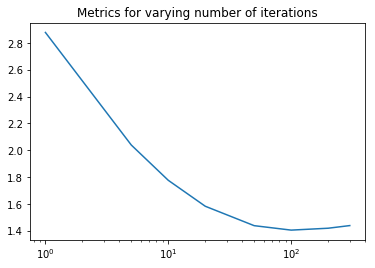

In [53]:
#plot a graph of the RMSLE metric against the number of iterations.
plt.plot(params, metrics)
fig = matplotlib.pyplot.gcf()
plt.xscale('log')
plt.title('Metrics for varying number of iterations')


In [54]:
#Step size
#We will perform a similar analysis for step size in the following code:
params = [0.01, 0.025, 0.05, 0.1, 0.2,0.4]
metrics = [evaluate(train_data, test_data, 10, param, 0.0, 'l2',
False) for param in params]
print params
print metrics



[0.01, 0.025, 0.05, 0.1, 0.2, 0.4]
[1.7761565324837874, 1.4379348243997032, 1.4189071944747718, 1.5027293911925559, 1.5384660954019973, 1.4948198206072132]


Text(0.5,1,u'Metrics for varying values of step size')

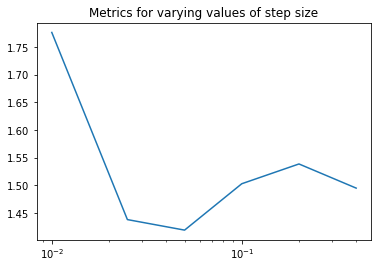

In [55]:
plt.plot(params, metrics)
fig = matplotlib.pyplot.gcf()
plt.xscale('log')
plt.title('Metrics for varying values of step size')


L2 regularization
Regularization has the effect of penalizing model complexity in the form of an additional loss term that is a function of the model weight vector. We will evaluate the impact of different levels of L2 regularization 


In [56]:
params = [0.0, 0.01, 0.1, 0.5, 1.0,3.0, 5.0, 10.0, 20.0]
metrics = [evaluate(train_data, test_data, 10, 0.1, param, 'l2',
False) for param in params]
print params
print metrics


[0.0, 0.01, 0.1, 0.5, 1.0, 3.0, 5.0, 10.0, 20.0]
[1.5027293911925559, 1.5020646031965639, 1.4961903335175231, 1.4724237224453407, 1.4479313176192781, 1.4004900385900405, 1.4113329999970989, 1.5379824584440471, 1.8279564444985839]


Text(0.5,1,u'Metrics for varying levels of L2 regularization')

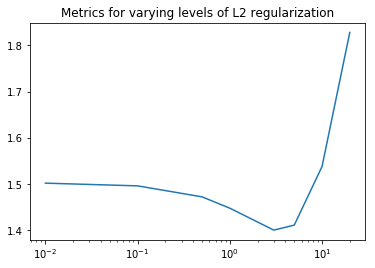

In [57]:
plt.plot(params, metrics)
fig = matplotlib.pyplot.gcf()
plt.xscale('log')
plt.title('Metrics for varying levels of L2 regularization')


L1 regularization
We can apply the same approach for differing levels of L1 regularization:


In [58]:
params = [0.0, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
metrics = [evaluate(train_data, test_data, 10, 0.1, param, 'l1', False) for param in params]
print params
print metrics




[0.0, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
[1.5027293911925559, 1.5026938950690176, 1.5023761634555697, 1.499412856617814, 1.4713669769550108, 1.7596682962964316, 4.7551250073268614]


Text(0.5,1,u'Metrics for varying levels of L1 regularization')

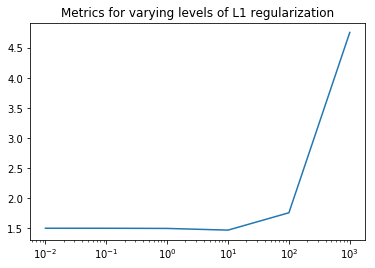

In [59]:
plt.plot(params, metrics)
fig = matplotlib.pyplot.gcf()
plt.xscale('log')
plt.title('Metrics for varying levels of L1 regularization')

Intercept

An intercept is a constant term that is added to the weight vector and effectively accounts for the mean value of the target variable. 

We will evaluate the effect of adding an intercept term to the model here:




In [60]:
params = [False, True]
metrics = [evaluate(train_data, test_data, 10, 0.1, 1.0, 'l2', param)
for param in params]
print params
print metrics


[False, True]
[1.4479313176192781, 1.4798261513419801]


The impact of parameter settings for the decision tree
Decision trees provide two main parameters: maximum tree depth and the maximum number of bins.
We create an evaluation function for the model, similar to the one used for the linear regression


In [61]:
def evaluate_dt(train, test, maxDepth, maxBins):
    model = DecisionTree.trainRegressor(train, {}, impurity='variance', maxDepth=maxDepth, maxBins=maxBins)
    preds = model.predict(test.map(lambda p: p.features))
    actual = test.map(lambda p: p.label)
    tp = actual.zip(preds)
    rmsle = np.sqrt(tp.map(lambda (t, p): squared_log_error(t,p)).mean())
    return rmsle


Tree depth
Now we will explore the depth of the tree. We would generally expect performance to increase with more complex trees.


In [62]:
params = [1, 2, 3, 4, 5,8, 10,15,20,30]
metrics = [evaluate_dt(train_data, test_data, param, 32) for
param in params]
print params
print metrics


[1, 2, 3, 4, 5, 8, 10, 15, 20, 30]
[1.5180698755025512, 1.4861824245882309, 1.4451649790528107, 1.408486119049464, 1.3540282148150857, 1.2390122521015714, 1.106353854645167, 0.73882898205683167, 0.60218451973793063, 0.56603328490729565]


Text(0.5,1,u'Metrics for different tree depths')

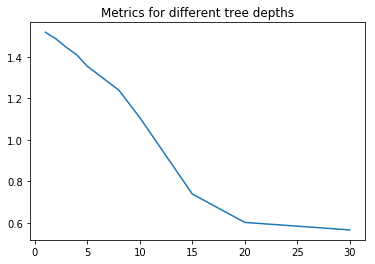

In [63]:
plt.plot(params, metrics)
fig = matplotlib.pyplot.gcf()
plt.title('Metrics for different tree depths')



Maximum bins

We will perform our evaluation on the impact of setting the number of bins for the decision tree. As with the tree depth, a larger number of bins should allow the model to become more complex and might help performance with larger feature
dimensions.


In [64]:
params = [2, 4, 8, 16, 32, 64, 80, 100]
metrics = [evaluate_dt(train_data, test_data, 5, param) for
param in params]
print params
print metrics


[2, 4, 8, 16, 32, 64, 80, 100]
[1.3559275822161809, 1.3547441915012883, 1.3548062474637748, 1.353996636371803, 1.3540282148150857, 1.3503754519074669, 1.3503754519074669, 1.3503754519074669]


Text(0.5,1,u'Metrics for different maximum bins')

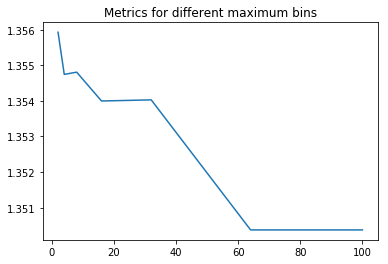

In [65]:
plt.plot(params, metrics)
fig = matplotlib.pyplot.gcf()
plt.title('Metrics for different maximum bins')
